# Web Scraper

In [ ]:
!pip install xlsxwriter

In [ ]:
import requests
import json
from bs4 import BeautifulSoup
import re
import pandas as pd
from collections import Counter
import xlsxwriter

In [ ]:
def extract_rating(book_div):
    # Find the container that holds the star ratings
    rating_container = book_div.find('div', class_='bc-review-stars')
    if not rating_container:
        return 'N/A'

    # Count full and half stars
    full_stars = rating_container.find_all('i', class_='bc-icon-star-fill-s2')
    half_stars = rating_container.find_all('i', class_='bc-icon-star-left-fill-s2')

    # Calculate the total rating
    total_rating = len(full_stars) + 0.5 * len(half_stars)
    return total_rating if total_rating > 0 else 'N/A'

def clean_text(text):
    extended_stop_words = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your",
    "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she",
    "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that",
    "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of",
    "at", "by", "for", "with", "about", "against", "between", "into", "through",
    "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once",
    "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
    "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only",
    "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just",
    "don", "should", "now"
    ]
    # Remove punctuation and split into words
    text = re.sub(r'[^\w\s]', '', text)
    words = text.lower().split()
    # Remove stop words
    return [word for word in words if word not in extended_stop_words]

def build_inverted_index(book_descriptions):
    words_apperence = {}
    # Process only the first 20 descriptions
    for index, description in enumerate(book_descriptions[:20]):  # Slice the first 20 descriptions
        words = clean_text(description)
        for word in words:
            if word not in words_apperence:
                words_apperence[word] = set()
            words_apperence[word].add(index+1)

    # Get the top 15 words that their set in words_apperence is the longest
    words_apperence = dict(sorted(words_apperence.items(), key=lambda x: len(x[1]), reverse=True)[:15])
    return words_apperence


def get_books_from_page(page_url):
    response = requests.get(page_url)
    content = response.content.decode('utf-8')  # Ensure using UTF-8 encoding
    soup = BeautifulSoup(content, 'html.parser')
    books = []

    # Extract books from the page
    book_divs = soup.find_all('div', class_='bc-col-responsive')  # Adjusted to target the new structure
    for book_div in book_divs:
        book_info = {}

        # Extract the title
        title_tag = book_div.find('h3', class_='bc-heading')
        book_info['title'] = title_tag.text.strip() if title_tag else 'Title not found'

        # Extract the author
        author_tag = book_div.find('li', string=lambda x: x and 'By:' in x)

        book_info["author"] = author_tag.text.strip().replace('By:', '').strip() if author_tag else 'Author not found'

        # Extract ratings
        book_info["overall_rating"] = extract_rating(book_div)

        # Extract the number of reviews
        review_count_tag = book_div.find('span', class_='bc-letter-space bc-letter-space-mini')
        book_info['review_count'] = review_count_tag.next_sibling.strip() if review_count_tag else 'Review count not found'

        # Extract description
        desc_tag = book_div.find('p', class_='bc-text')
        book_info['description'] = desc_tag.text.strip() if desc_tag else 'Description not found'

        books.append(book_info)

    # Check if this is the last page
    results_summary = soup.find('span', class_='resultsSummarySubheading')
    if results_summary:
        results_text = results_summary.text.strip()
        current_range, total = results_text.split(' of ')
        # print(current_range,total)
        is_last_page = current_range.split(' - ')[1] == total.split(' ')[0]

    return books, is_last_page

def get_all_books(book_name, max_pages=20):
    base_url = "https://www.audible.com/search"
    all_books = []

    page = 1
    while page <= max_pages:
        search_url = f"{base_url}?keywords={book_name.replace(' ', '+')}&page={page}"
        books, is_last_page = get_books_from_page(search_url)
        all_books.extend(books)
        if is_last_page:
            break
        page += 1

    # Filter and select books with the most complete data
    filter_books=[book for book in all_books if book["title"]!='Title not found']
    filtered_books = filter_books_for_best_data(filter_books)
    return filtered_books

def filter_books_for_best_data(books):
    # Convert list of dictionaries to a DataFrame
    df = pd.DataFrame(books)

    # Define a ranking system based on the presence of non-null and non-'N/A' data
    conditions = [
        (df['author'] != 'Author not found') & (df['author'].notna()),
        (df['overall_rating'] != 'N/A') & (df['overall_rating'].notna()),
        (df['review_count'] != 'Review count not found') & (df['review_count'].notna()),
        (df['description'] != 'Description not found') & (df['description'].notna())
    ]
    # Assign scores based on conditions met (more conditions met -> higher score)
    df['data_completeness_score'] = sum([conditions[i].astype(int) for i in range(len(conditions))])

    # Sort by completeness score and drop duplicates keeping the entry with the highest score
    df = df.sort_values(by='data_completeness_score', ascending=False).drop_duplicates(subset=['title'], keep='first')
    df = df.drop(columns=['data_completeness_score'])
    # Convert DataFrame back to list of dictionaries
    filtered_books = df.to_dict('records')
    return filtered_books

#query 1 : get all the books that have full vairable (rate,author,rate,review count and more)
def get_books_with_all_details(all_books):
    filtered_books = [
        book for book in all_books
        if book["title"] != 'Title not found' and book["author"] != 'Author not found'
        and book["overall_rating"] != 'N/A' and book["review_count"] != 'Review count not found'
        and book["review_count"] !='' and book["description"] != 'Description not found'
    ]
    return filtered_books

#query 2:get all the books seaech that their rate up from 4.5
def get_books_with_rate_up_four_and_half(all_books):
    filtered_books = [
        book for book in all_books
        if book.get("overall_rating") not in ('N/A', '', None)  # Ensure the rating is not invalid
        and float(book["overall_rating"]) > 4.5  # Convert string to float and compare
    ]
    return filtered_books

#query 3:get all the books of the most common author
def get_books_by_most_common_author(all_books):
    # Calculate the frequency of each author
    author_count = Counter(book['author'] for book in all_books if book['author'] != 'Author not found')

    # Find the most common author
    most_common_author = author_count.most_common(1)[0][0] if author_count else None

    # Filter books to only include those by the most common author
    if most_common_author:
        return [book for book in all_books if book['author'] == most_common_author]
    else:
        return []


def export_books_to_excel(book_data, filename):
    # Create a Pandas Excel writer using XlsxWriter as the engine within a context manager
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        for sheet_name, data in book_data.items():
            df = pd.DataFrame(data)
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    # The file is saved and closed automatically when exiting the 'with' block

    try:
        from google.colab import files
        files.download(filename)  # Try to download if in a Colab environment
    except ImportError:
        print(f"Excel file '{filename}' has been created and saved locally.")  # Local Python environments

In [ ]:
book_name = "It ends with Us"
all_books = get_all_books(book_name)

books_with_all_details = get_books_with_all_details(all_books)
books_with_high_ratings = get_books_with_rate_up_four_and_half(all_books)
books_by_most_common_author = get_books_by_most_common_author(all_books)

book_data = {
    "Query 1 - All Details": books_with_all_details,
    "Query 2 - High Ratings": books_with_high_ratings,
    "Query 3 - Most Common Author": books_by_most_common_author
}

export_books_to_excel(book_data,"full_detail.xlsx")

for query_name, books in book_data.items():
    print(f"\n{query_name}: {len(books)} books found")
    for book in books:
        print(f"- {book['title']} by {book['author']}, Rating: {book.get('overall_rating', 'N/A')}, Reviews: {book.get('review_count', 'N/A')}")

# Display common words analysis
descriptions = [book['description'] for book in books_with_all_details]
words_apperence = build_inverted_index(descriptions)
print("\nTop 15 most common words in descriptions [all_details]:")
for word in words_apperence:
    print(f"{word}: {len(words_apperence[word])}")
    print(f"{word}: {sorted(words_apperence[word])}")

descriptions = [book['description'] for book in books_with_high_ratings]
words_apperence = build_inverted_index(descriptions)
print("\nTop 15 most common words in descriptions [high_ratings]:")
for word in words_apperence:
    print(f"{word}: {len(words_apperence[word])}")
    print(f"{word}: {sorted(words_apperence[word])}")


descriptions = [book['description'] for book in books_by_most_common_author]
words_apperence = build_inverted_index(descriptions)
print("\nTop 15 most common words in descriptions [most_common_author]:")
for word in words_apperence:
    print(f"{word}: {len(words_apperence[word])}")
    print(f"{word}: {sorted(words_apperence[word])}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Query 1 - All Details: 45 books found
- This Is Me Letting You Go by Heidi Priebe, Rating: 4.5, Reviews: 1,503
- It Didn't Start with You by Mark Wolynn, Rating: 4.5, Reviews: 2,475
- One of Us Is Lying (TV Series Tie-In Edition) by Karen M. McManus, Rating: 4.5, Reviews: 7,948
- It Ends With Her by Brianna Labuskes, Rating: 4.0, Reviews: 1,023
- Healing the Shame That Binds You by John Bradshaw, Rating: 4.5, Reviews: 1,040
- Free Audiobooks by Appbly.com, Rating: 4.5, Reviews: 6
- Would Like to Meet by Rachel Winters, Rating: 3.5, Reviews: 2
- Unf--k Your Brain by Faith G. Harper PhD LPC-S ACS ACN, Rating: 4.0, Reviews: 18,952
- It's Not Hysteria by Dr. Karen Tang, Rating: 5.0, Reviews: 8
- George Orwell’s 1984 by George Orwell, Joe White - adaptation, Rating: 4.5, Reviews: 5,686
- It Happened One Summer by Tessa Bailey, Rating: 4.5, Reviews: 5,431
- Good Energy by Casey Means MD, Calley Means, Rating: 4.5, Reviews: 222
- Atomic Habits by James Clear, Rating: 5.0, Reviews: 136,318
- 

In [ ]:
import numpy as np

def page_rank(links, damping_factor=0.85, iterations=1):
    N = len(links)
    M = np.zeros((N, N))

    for j in range(N):
        for i in links[j]:
            out_links = len(links[i])
            if out_links!=0:
               M[i-1, j] = 1 / out_links  # Set transition probability if moving from page j to page i

    R = np.ones(N) / N  # Initialize R(p) to 1/N for all p
    d = damping_factor

    # Use explicit summation instead of matrix multiplication
    for _ in range(iterations):
        new_R = np.zeros(N)
        for p in range(N):
            sum_contributions = 0
            for j in range(N):
                if M[p, j] > 0:  # There is a link from j to p
                    sum_contributions += R[j] * M[p, j]
            new_R[p] = (1 - d) / N + d * sum_contributions
        R = new_R
    print("Transition Matrix M:\n", M)
    print("Initial Rank Vector R:\n", R)
    return R

# Example structure based on the given links
links = [
    [2, 4],      # Book 1 links to Book 2 and Book 4
    [],          # Book 2 links to no other book
    [],          # Book 3 links to no other book
    [1],         # Book 4 links to Book 1
    [1, 8],      # Book 5 links to Book 1 and Book 8
    [7, 5],      # Book 6 links to Book 7 and Book 5
    [6, 5],      # Book 7 links to Book 6 and Book 5
    [2],         # Book 8 links to Book 2
    [],          # Book 9 links to no other book
    [1, 2]       # Book 10 links to Book 1 and Book 2
]
# 0.0575= 0.015+ 0.85* ((1/10/0))
#0.015 = 0.015 + 0.85 *((1/10/0)+(1/1/))
page_ranks = page_rank(links)

print("Page Ranks:", page_ranks)


Transition Matrix M:
 [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
Initial Rank Vector R:
 [0.015  0.015  0.015  0.0575 0.1    0.0575 0.1    0.015  0.015  0.015 ]
Page Ranks: [0.015  0.015  0.015  0.0575 0.1    0.0575 0.1    0.015  0.015  0.015 ]


Page ranks for iteration 1:
['0.248322', '0.248322', '0.020134', '0.077181', '0.134228', '0.077181', '0.077181', '0.077181', '0.020134', '0.020134']
Page ranks for iteration 16:
['0.273132', '0.259947', '0.020088', '0.177826', '0.073404', '0.046746', '0.046746', '0.061936', '0.020088', '0.020088']
Page ranks for iteration 30:
['0.274901', '0.258965', '0.020113', '0.176878', '0.073422', '0.046768', '0.046768', '0.061958', '0.020113', '0.020113']
Final PageRank after 30 iterations:
Page 1: 0.274901
Page 2: 0.258965
Page 3: 0.020113
Page 4: 0.176878
Page 5: 0.073422
Page 6: 0.046768
Page 7: 0.046768
Page 8: 0.061958
Page 9: 0.020113
Page 10: 0.020113


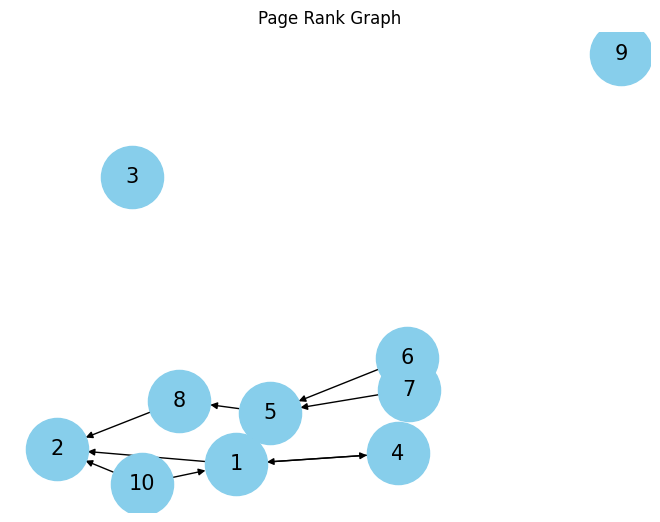

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def page_rank(links, damping_factor=0.85, iterations=100):
    N = len(links)
    PR = np.ones(N) / N

    for iteration in range(iterations):
        new_PR = np.zeros(N)

        for i in range(N):
            # Calculate only the d * Σ (PR(pj) / |out(pj)|) part
            for j in range(N):
                if i + 1 in links[j]:
                    out_links = len(links[j])
                    if out_links > 0:
                        new_PR[i] += damping_factor * (PR[j] / out_links)

            # Add the (1-d)/N part after summing all contributions
            new_PR[i] += (1 - damping_factor) / N

        PR = new_PR / new_PR.sum()  # Normalize to ensure the sum is 1

        if iteration == 0 or iteration == iterations // 2 or iteration == iterations - 1:
            formatted_PR = [f"{rank:.6f}" for rank in PR]
            print(f"Page ranks for iteration {iteration + 1}:\n{formatted_PR}")

    return PR

links = [
    [2, 4],      # Book 1 links to Book 2 and Book 4
    [],          # Book 2 links to no other book
    [],          # Book 3 links to no other book
    [1],         # Book 4 links to Book 1
    [1, 8],      # Book 5 links to Book 1 and Book 8
    [7, 5],      # Book 6 links to Book 7 and Book 5
    [6, 5],      # Book 7 links to Book 6 and Book 5
    [2],         # Book 8 links to Book 2
    [],          # Book 9 links to no other book
    [1, 2]       # Book 10 links to Book 1 and Book 2
]
def plot_graph(links):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for i in range(1, 11):
        G.add_node(i)
    for i, linked_books in enumerate(links, 1):
        for linked in linked_books:
            G.add_edge(i, linked)

    # Layout for the nodes in the graph
    pos = nx.spring_layout(G)

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='k', linewidths=1, font_size=15)
    plt.title('Page Rank Graph')
    plt.show()
iterations = 30
page_ranks = page_rank(links, iterations=iterations)
print(f"Final PageRank after {iterations} iterations:")
for i, rank in enumerate(page_ranks):
    print(f"Page {i+1}: {rank:.6f}")
# Plot the graph
plot_graph(links)